# GAN Model for Generating Handwritten Digits useing MNIST

## Import libraries

In [1]:
import tensorflow as tf
from tensorflow import keras

from keras import layers, Input, Sequential
from keras.layers import Dense, BatchNormalization, ReLU, LeakyReLU, Reshape
from keras.layers import Conv2D, Conv2DTranspose, Dropout, Flatten
from keras.models import Model
from keras.utils import plot_model
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import time
from tqdm.auto import tqdm


2024-05-05 23:29:17.593881: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## MINST dataset from keras 

In [2]:
data_mnist = keras.datasets.mnist.load_data()

(x_tr, y_tr), (x_ts, y_ts) = data_mnist

In [3]:
x_tr.shape

(60000, 28, 28)

In [4]:
x_ts.shape

(10000, 28, 28)

In [5]:
# reshape x_train as a 4d vector (60000,28,28,1), where 1 refers to the number of channels. 
# These are grayscale images, therefore, number of channels = 1

x_tr = x_tr.reshape(x_tr.shape[0],x_tr.shape[1], x_tr.shape[2],1)
x_tr = tf.cast(x_tr, tf.float32)
x_tr=(x_tr-127.5)/127.5



In [6]:
#convert values into a tensor that takes float values

x_ts = x_ts.reshape(x_ts.shape[0],x_ts.shape[1], x_ts.shape[2],1)
x_ts = tf.cast(x_ts, tf.float32)
x_ts = (x_ts-127.5)/127.5

In [7]:
x_ts.shape

TensorShape([10000, 28, 28, 1])

In [8]:
#create tensor slices from x_train

BATCH_SIZE = 256
BUFFER_SIZE = x_tr.shape[0]
latent_dim = 100

x_train = tf.data.Dataset.from_tensor_slices(x_tr).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
x_test = tf.data.Dataset.from_tensor_slices(x_ts).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
x_train, x_test

(<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>,
 <_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>)

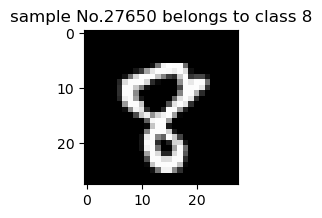

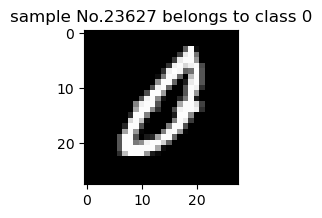

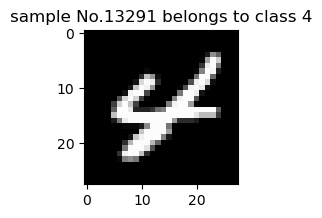

In [9]:
# display randomly chosen images from x_train

for r in np.random.randint(0, 59999, size=3, dtype=int):
    plt.figure(figsize=(2,2))
    plt.imshow(x_tr[r,:,:,0], cmap='grey')
    plt.title("sample No.{} belongs to class {}".format(r,y_tr[r]))
    

# Build GAN 

## Generator

Parameters to note:

- Noise : 1x1 100-dim vector
- Start by 'generating' a 7x7 low resolution image map from the 100-dim noise vector
- batch_size = 256. x_train tensor slices are passed into the model in batches = batch_size

Generator NN

- block 1
    - layer 1 = Dense with 7*7*256 neurons 
    - layer 2 = BatchNormalization 
    - layer 3 = activation (say, Relu) 
    - layer 4 = reshape output to (batch=none, 7, 7, 256) 
    <br>
    <br>
- block 2 <br>
    - layer 4 = Conv2D with filters/output = 128, kernal_size=3, strides = 2 
    - layer 5 = BatchNormalization 
    - layer 6 = activation 
    <br>
    <br>
- block 3 <br>
    - layer 7 = Conv2D with filters/output = 64, kernal_size=3, strides = 2 
    - layer 8 = BatchNormalization 
    - layer 9 = activation 
    <br>
    <br>
- block 4 <br>
    - layer 10 = Conv2D with filters/output = 1, kernal_size=3, strides = 2 
    - layer 11 = BatchNormalization 
    - layer 12 = activation 
    <br>
    <br>


In [10]:
def build_generator():
    
    gen = Sequential()
    
    #block-1
    gen.add(Dense(7*7*256, input_shape=(latent_dim,), use_bias=False))
    gen.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn-1'))
    gen.add(ReLU(name="RelU-1"))
    gen.add(Reshape((7,7,256)))
    
    #block-2
    gen.add(Conv2DTranspose(128, kernel_size=5, strides=1, padding='same',use_bias=False, name='Conv2dT-1'))
    assert gen.output_shape == (None, 7, 7, 128)
    gen.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn-2'))
    gen.add(ReLU(name="RelU-2"))

    
    #block-3
    gen.add(Conv2DTranspose(64, kernel_size=5, strides=2,padding='same',use_bias=False, name='Conv2dT-2'))
    assert gen.output_shape == (None, 14, 14, 64)
    gen.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn-3'))
    gen.add(ReLU(name="RelU-3"))
    
    #block-4
    gen.add(Conv2DTranspose(1, kernel_size=5, strides=2,padding='same',use_bias=False, name='Conv2dT-3',
                           activation = 'tanh'))
    assert gen.output_shape == (None, 28, 28, 1)
    
    return gen

### Generator model summary

In [11]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 bn-1 (BatchNormalization)   (None, 12544)             50176     
                                                                 
 RelU-1 (ReLU)               (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 Conv2dT-1 (Conv2DTranspose  (None, 7, 7, 128)         819200    
 )                                                               
                                                                 
 bn-2 (BatchNormalization)   (None, 7, 7, 128)         512       
                                                        

In [12]:
print("The number of layers in the generator = {}".format(len(generator.layers)))
#plot_model(generator, show_shapes=True, show_dtype=True, show_layer_names=False)

The number of layers in the generator = 11


### Create generated image (w/o training)

In [13]:
# create a tf noise tensor 
noise = tf.random.normal([1,latent_dim])
generated_image = generator(noise, training=False)
generated_image.shape


TensorShape([1, 28, 28, 1])

Text(0.5, 1.0, 'Generated Image from normal distribution')

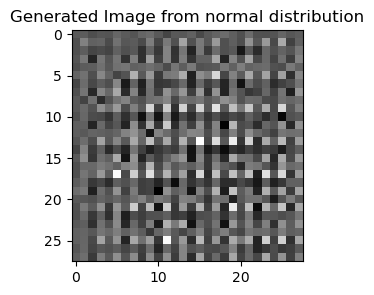

In [14]:
plt.figure(figsize=(3,3))
plt.imshow(generated_image[0,:,:,0]*127.5 + 127.5, cmap='grey')
plt.title("Generated Image from normal distribution")

In [15]:
#noise = tf.random.poisson([1,100],[0.5])
#generated_image_P = generator(noise, training=False)
#generated_image_P.shape

In [16]:
#plt.figure(figsize=(3,3))
#plt.imshow(generated_image_P[0,:,:,0]*127.5 + 127.5, cmap='grey')
#plt.title("Generated Image from Poisson Distriution")

## Discriminator

Parameters and Structure:

We will use the sequntial model for the discriminator as well. 

- block 1
    - layer 1 : Input layer of shape (28,28,1)
    - layer 2 : conv2d with filters = 64, kernel_size = (5,5), strides = (2,2), padding = "same"
    - layer 3 : activation(leaky ReLU)
    - layer 4 : dropout to reduce overfitting (0.3)        
    <br>
    <br>
- block 2
    - layer 1 : conv2d with filters = 128, kernel_size = (5,5), strides = (2,2), padding = "same"
    - layer 2 : BatchNormalization
    - layer 3 : activation(leaky ReLU)
    - layer 4 : dropout to reduce overfitting (0.3)
    <br>
    <br>        
- block 3
    - layer 1 : conv2d with filters = 1, kernel_size = (5,5), strides = (2,2), padding = "same"
    - layer 2 : activation(Sigmoid)

In [17]:
def build_discriminator():
    
    dis = Sequential()
    
    # block-1
    dis.add(Input(shape=(28,28,1)))
    dis.add(Conv2D(64, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False, name='Conv2D-1'))
    dis.add(LeakyReLU())
    dis.add(Dropout(0.3))
    
    # block-2
    dis.add(Conv2D(128, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False, name='Conv2D-2'))
    dis.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn-1'))
    dis.add(LeakyReLU())
    dis.add(Dropout(0.3))

    # block-3
    dis.add(Flatten())
    dis.add(Dense(1, name='Dense'))#, activation = 'sigmoid'))
    
    
    return dis

### Discriminator model summary

In [18]:
discriminator = build_discriminator()
discriminator.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D-1 (Conv2D)           (None, 14, 14, 64)        1600      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 Conv2D-2 (Conv2D)           (None, 7, 7, 128)         204800    
                                                                 
 bn-1 (BatchNormalization)   (None, 7, 7, 128)         512       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)        

In [19]:
print("The number of layers in the generator = {}".format(len(discriminator.layers)))
#plot_model(discriminator, show_dtype=True, show_shapes=True, show_layer_names=False)

The number of layers in the generator = 9


### Discriminator decision - real or fake

In [20]:
def decision(disc_output):
    
    val = disc_output.numpy()[0,0]
    if val < 0:
        print("Generated Image")
    else:
        print("Real Image")
              
    return

In [21]:
disc_output = discriminator(generated_image)
disc_output.numpy()[0,0]

0.00033276784

In [22]:
decision(disc_output)

Real Image


## Loss functions & Optimizers

Two loss functions are necessary for a GAN model- one to compute the loss for the generator (L_gen) and another to compute the loss for the discriminator (L_dis).

- L_dis : 
    This function will compute loss for whether the discriminator correctly identifies the image as real or fake. The discriminator is passed real and fake images. The output of these images (O_real and O_fake) are then compared to their respective labels (1 for real and 0 for fake) and the binary cross entropy loss is then computed accordingly. 
    
- L_gen :
    This function determines loss by comparing the output of fake images from the discriminator (O_fake) with the labels for the real images (1s). In other words, this loss function indicates how close the fake image is to the real image. 
    
- Goal :
    The objective is to get the discriminator to accurately and correctly identify real from fake images with training and for the generator to create fake images as close to the real images as possible.  

### Loss Fcuntion
    Outputs : Generator loss L_gen and Total discriminator loss L_dis

In [23]:
def loss_gen(Xf):

    BCE = BinaryCrossentropy(from_logits=True)
    
    l_gen = BCE(tf.ones_like(Xf), Xf)
       
    return l_gen 

def loss_dis(Xr,Xf):

    BCE = BinaryCrossentropy(from_logits=True)
    
    l_dis_r = BCE(tf.ones_like(Xr),Xr)
    l_dis_f = BCE(tf.zeros_like(Xf),Xf)

    l_dis = 0.5*(l_dis_r + l_dis_f)
    
    return l_dis

In [24]:
Xgen = generator(noise, training=False) # generated image from noise
Xfake = discriminator(Xgen, training=False) # discriminator output from generated image

loss_gen(Xfake)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6929808>

In [25]:
# TESTING loss functions and discriminator decisions !!! 

seed = tf.random.normal([1, 100])
#seed = tf.random.poisson([1,100],[0.5])

#print(seed, "\n")

generator = build_generator()
discriminator = build_discriminator()

count=0
for x in x_train:
   
    xgen = generator(seed, training=False)
    xr = discriminator(x, training=False)
    xf = discriminator(xgen, training=False)

    lg = loss_gen(xf)
    ld = loss_dis(xr,xf)

    prediction = decision(xf)

    print(prediction, xf.numpy())

    count += 1
    if count > 5:
        break
    
    

Real Image
None [[0.00027179]]
Real Image
None [[0.00027179]]
Real Image
None [[0.00027179]]
Real Image
None [[0.00027179]]
Real Image
None [[0.00027179]]
Real Image
None [[0.00027179]]


### Optimizers

In [26]:
def run_adam_legacy_optimizer():
    generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)
    discriminator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)

## Create Training Function

Steps followed:

    1. start by sampling a random normal noise vector
    2. generating an image (Xgen) by passing the noise to the generator
    3. pass the generated image (Xgen) along with the real image (Xreal) into the discriminator
    4. compute generator loss, L_g, and the total discriminator loss, L_d by comparing the output of the discriminator to the real and fake images. 
    5. compute gradients for the generator and the discriminator using the loss computed above
    6. update the generator and discriminator optimizers defined above (gen_opt and dis_opt) using the gradients 
    

In [27]:
generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005, beta_1 = 0.5, beta_2 = 0.999 )
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005, beta_1 = 0.5, beta_2 = 0.999 )

@tf.function

def GAN_train(X):

    '''
    X is the real image passed in from the datatset
    Xgen is the image created from initial noise from the generator 
    Xreal is the image created by the discriminator when the real image X is passed into it
    Xfake is the image created by the discriminator when a generated image (Xgen) is passed into it
    
    '''
    
    # step 1 : Sample noise 
    # latent_dim = 100 is the dimension of the noise vector

    #latent_dim = 100
    print("batch size called inside the training step function is {}".format(BATCH_SIZE))
    noise = tf.random.normal([BATCH_SIZE, latent_dim])
    #noise = tf.random.poisson([BATCH_SIZE, latent_dim], [0.5])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
     
        # step 2 : 
        Xgen = generator(noise, training=True) # output from noise
        
        Xreal = discriminator(X, training=True) # outout from real data
        Xfake = discriminator(Xgen, training=True) # output from generated data
        
        # step 3 :
        gen_loss = loss_gen(Xfake)
        dis_loss = loss_dis(Xreal,Xfake)

    #step 4 : Compute the gradients 
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = dis_tape.gradient(dis_loss, discriminator.trainable_variables)
        
    #step 5 : Apply gradients to optomizers
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))    
    


## The complete GAN model 


In [28]:
def GAN_model(dataset, EPOCHS):

    generator = build_generator()
    discriminator = build_discriminator()

    start_main = time.time()

    for epoch in range(EPOCHS):
    
        start = time.time()
        i=0
    
        for X in tqdm(dataset, desc=f"epoch {epoch+1}", total=len(x_train)):
        
            i+=1
            GAN_train(X)
        
        print ('Time for epoch {} is {} min'.format(epoch + 1, (time.time()-start)/60), "\n")
        
    print("Total iterations per epoch {}".format(i))
    print('Total time taken for the complete run over {} epochs is {} hours'.format(epoch + 1, (time.time()-start_main)/3600))

    

In [29]:
def run_DCGAN(x_train, x_test, EPOCHS):

    print("................\n")
    print("Calling GAN \n\n")
    print("batch size = ", BATCH_SIZE)
    print("EPOCHS = ", EPOCHS)
    print("latent_dim = ", latent_dim, "\n")
    print("................\n")
        
    GAN_model(x_train, EPOCHS)    
    
    # generate images after training the generator
    samples = 16
    noise_samples=tf.random.normal([samples, 100])
    #noise_samples = tf.random.poisson([samples, latent_dim],[0.5])
    
    gen_image = generator(noise_samples, training=False)
    
    
    # plot generated samples
    fig = plt.figure(figsize=(4, 4))
    
    plt.title("AI Image after {} epochs".format(EPOCHS))
    for i in range(gen_image.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(gen_image[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    
    plt.show()
    
    print(".........................\n")
    print(".........................\n")
    print(".........................\n")
    
    generate_image(EPOCHS)
    
    run_percentage_error(x_test)


### Helper functions

#### generate image

In [30]:
# generate images after training the generator

def generate_image(EPOCHS): 
    
    samples = 16
    noise_samples=tf.random.normal([samples, 100])
    #noise_samples=tf.random.poisson([samples, latent_dim],[0.5])
    
    gen_image = generator(noise_samples, training=False)
    
    
    # plot generated samples
    fig = plt.figure(figsize=(4, 4))
    
    plt.title("AI Image after {} epochs".format(EPOCHS))
    for i in range(gen_image.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(gen_image[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    
    plt.show()


# Error Rate/Accuracy

In [31]:
def percentage_error(x_test):
    
    # % error for original test images
    
    correct_xTest = 0
    incorrect_xTest = 0
    
    for org_test_image in x_test:
        
        disc_result = discriminator(tf.expand_dims(org_test_image[0,:,:,:], axis=0))
    
        #decision(disc_result)
        #print(disc_result.numpy()[0,0])
        
        if disc_result.numpy()[0,0] > 0:
            correct_xTest +=1 
        else:
            incorrect_xTest +=1
    
    
    percentage_correct_xTest = (correct_xTest*100)/len(x_test)
    print("\n\n")
    
    # % error for generated images
    correct_xgen = 0
    incorrect_xgen = 0
    
    for i in range(0, len(x_test)):
    
        # show images
        noise = tf.random.normal([1, 100])
        #noise = tf.random.poisson([1, latent_dim],[0.5])
        
        generated_image = generator(noise, training=False)
    
        disc_result_xgen = discriminator(generated_image)
    
        #decision(disc_result_xgen)
        #print(disc_result_xgen.numpy()[0,0])
        
        if disc_result_xgen.numpy()[0,0] < 0:
            correct_xgen +=1 
        else:
            incorrect_xgen +=1
        
    percentage_correct_xgen = (correct_xgen*100)/len(x_test)
    percentage_incorrect_xgen = (incorrect_xgen*100)/len(x_test)
    
    return percentage_correct_xTest, percentage_correct_xgen, percentage_incorrect_xgen

In [32]:
def run_percentage_error(x_test):
    
    error_rate_for_correct_orignal, error_rate_for_correct_generated, error_rate_for_incorrect_generated = percentage_error(x_test)
    
    print("Percentage of correct predictions from the discriminator for ORIGINAL TEST images is {}".format(error_rate_for_correct_orignal))
    
    print("Percentage of correct predictions from the discriminator for GENERATED images is {}".format(error_rate_for_correct_generated))
    print("Percentage of INcorrect predictions from the discriminator for GENERATED images is {}".format(error_rate_for_incorrect_generated))
   

# Hyperparameter Analysis

- Epochs Tuning
    1. how many epochs are sufficient .. 25, 50, 100, 200?
    2. Does the run time linearly increase with number of epochs?
       
- Batch_size
    1. for a fixed number of epochs, how does the batch_size influence the runtime?
    2. for a fixed number of epochs, how does the batch_size affect the learning/prediction?

- Deep Tuning
    1. How does the depth of the DCGAN afect run time?
    2. How does the depth discriminator error rate (for fixed epoch and batch_size)?


## Epochs

................

Calling GAN 


batch size =  256
EPOCHS =  200
latent_dim =  100 

................



epoch 1:   0%|          | 0/235 [00:00<?, ?it/s]

batch size called inside the training step function is 256
batch size called inside the training step function is 256
batch size called inside the training step function is 256
Time for epoch 1 is 3.057417949040731 min 



epoch 2:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 2 is 3.010273583730062 min 



epoch 3:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 3 is 3.0080835819244385 min 



epoch 4:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 4 is 2.99123139778773 min 



epoch 5:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 5 is 2.9779041330019633 min 



epoch 6:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 6 is 2.984822682539622 min 



epoch 7:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 7 is 2.980860869089762 min 



epoch 8:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 8 is 2.98864141702652 min 



epoch 9:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 9 is 2.9808418194452924 min 



epoch 10:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 10 is 2.9952008008956907 min 



epoch 11:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 11 is 3.0029505292574563 min 



epoch 12:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 12 is 3.0248528321584067 min 



epoch 13:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 13 is 2.9914976517359415 min 



epoch 14:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 14 is 2.9704746047655743 min 



epoch 15:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 15 is 2.9825979669888816 min 



epoch 16:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 16 is 2.9765790661176044 min 



epoch 17:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 17 is 2.984083831310272 min 



epoch 18:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 18 is 2.9873379866282144 min 



epoch 19:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 19 is 3.0001855651537577 min 



epoch 20:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 20 is 3.0098190029462177 min 



epoch 21:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 21 is 2.9850001335144043 min 



epoch 22:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 22 is 3.001586099465688 min 



epoch 23:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 23 is 2.999904970328013 min 



epoch 24:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 24 is 2.9832447806994122 min 



epoch 25:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 25 is 3.0089620272318522 min 



epoch 26:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 26 is 3.010347330570221 min 



epoch 27:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 27 is 2.986184052626292 min 



epoch 28:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 28 is 3.010997982819875 min 



epoch 29:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 29 is 2.997464883327484 min 



epoch 30:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 30 is 2.9998531341552734 min 



epoch 31:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 31 is 2.979146500428518 min 



epoch 32:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 32 is 2.9795210997263593 min 



epoch 33:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 33 is 2.987370316187541 min 



epoch 34:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 34 is 2.955427400271098 min 



epoch 35:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 35 is 2.982321870326996 min 



epoch 36:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 36 is 2.9829354484876 min 



epoch 37:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 37 is 2.979012588659922 min 



epoch 38:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 38 is 3.0009187976519267 min 



epoch 39:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 39 is 2.981578167279561 min 



epoch 40:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 40 is 2.9915224154790243 min 



epoch 41:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 41 is 2.983349136511485 min 



epoch 42:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 42 is 2.989400049050649 min 



epoch 43:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 43 is 3.0064049482345583 min 



epoch 44:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 44 is 2.967789653937022 min 



epoch 45:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 45 is 2.995839520295461 min 



epoch 46:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 46 is 2.988419532775879 min 



epoch 47:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 47 is 2.9652012825012206 min 



epoch 48:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 48 is 2.9962660034497577 min 



epoch 49:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 49 is 2.9923081199328103 min 



epoch 50:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 50 is 2.9831926147143046 min 



epoch 51:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 51 is 2.9920032342274983 min 



epoch 52:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 52 is 2.996947232882182 min 



epoch 53:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 53 is 3.0056957999865213 min 



epoch 54:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 54 is 2.9823734839757283 min 



epoch 55:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 55 is 3.0116637984911603 min 



epoch 56:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 56 is 3.0146310647328693 min 



epoch 57:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 57 is 3.0088043491045635 min 



epoch 58:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 58 is 3.009696884950002 min 



epoch 59:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 59 is 2.9944632212320963 min 



epoch 60:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 60 is 3.010188833872477 min 



epoch 61:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 61 is 3.0059388160705565 min 



epoch 62:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 62 is 2.982404347260793 min 



epoch 63:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 63 is 3.0073536674181622 min 



epoch 64:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 64 is 3.0050708691279095 min 



epoch 65:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 65 is 2.9933332204818726 min 



epoch 66:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 66 is 2.9882346987724304 min 



epoch 67:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 67 is 3.0120741526285806 min 



epoch 68:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 68 is 3.0003283818562827 min 



epoch 69:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 69 is 2.994130333264669 min 



epoch 70:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 70 is 3.0012784361839295 min 



epoch 71:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 71 is 3.019601265589396 min 



epoch 72:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 72 is 3.016585882504781 min 



epoch 73:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 73 is 3.0144490361213685 min 



epoch 74:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 74 is 2.9973244667053223 min 



epoch 75:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 75 is 3.019093668460846 min 



epoch 76:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 76 is 2.9956795016924542 min 



epoch 77:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 77 is 3.0008878310521445 min 



epoch 78:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 78 is 2.9955744822820027 min 



epoch 79:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 79 is 2.9809894363085427 min 



epoch 80:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 80 is 2.9932419220606485 min 



epoch 81:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 81 is 2.9964969317118326 min 



epoch 82:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 82 is 2.986501963933309 min 



epoch 83:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 83 is 2.9954405665397643 min 



epoch 84:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 84 is 3.00026269753774 min 



epoch 85:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 85 is 2.9874553442001344 min 



epoch 86:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 86 is 2.995018204053243 min 



epoch 87:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 87 is 3.016875386238098 min 



epoch 88:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 88 is 2.9836135546366376 min 



epoch 89:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 89 is 2.9905267198880514 min 



epoch 90:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 90 is 3.0094627857208254 min 



epoch 91:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 91 is 3.0043784300486247 min 



epoch 92:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 92 is 2.993054950237274 min 



epoch 93:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 93 is 3.013217798868815 min 



epoch 94:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 94 is 2.9959567824999493 min 



epoch 95:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 95 is 3.0100504318873087 min 



epoch 96:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 96 is 3.0224812189737955 min 



epoch 97:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 97 is 3.0130074342091877 min 



epoch 98:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 98 is 3.0146307667096455 min 



epoch 99:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 99 is 2.9885276794433593 min 



epoch 100:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 100 is 2.9892008463541666 min 



epoch 101:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 101 is 2.994111116727193 min 



epoch 102:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 102 is 2.9872889637947084 min 



epoch 103:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 103 is 3.0170042514801025 min 



epoch 104:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 104 is 3.007954482237498 min 



epoch 105:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 105 is 2.9903088172276813 min 



epoch 106:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 106 is 2.9955646832784018 min 



epoch 107:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 107 is 3.001115067799886 min 



epoch 108:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 108 is 2.9869484027226765 min 



epoch 109:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 109 is 3.0023966511090596 min 



epoch 110:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 110 is 3.0042129834493 min 



epoch 111:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 111 is 3.0113528847694395 min 



epoch 112:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 112 is 3.015177853902181 min 



epoch 113:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 113 is 3.0226711789766947 min 



epoch 114:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 114 is 3.007318985462189 min 



epoch 115:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 115 is 3.0164528012275698 min 



epoch 116:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 116 is 3.0099770148595173 min 



epoch 117:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 117 is 3.009787650903066 min 



epoch 118:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 118 is 3.00887318054835 min 



epoch 119:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 119 is 2.990419697761536 min 



epoch 120:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 120 is 2.9910921812057496 min 



epoch 121:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 121 is 2.9911604523658752 min 



epoch 122:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 122 is 2.9880337357521056 min 



epoch 123:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 123 is 2.9873849987983703 min 



epoch 124:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 124 is 3.001076817512512 min 



epoch 125:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 125 is 2.9922399878501893 min 



epoch 126:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 126 is 3.007461953163147 min 



epoch 127:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 127 is 2.994297365347544 min 



epoch 128:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 128 is 2.996894586086273 min 



epoch 129:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 129 is 2.995909253756205 min 



epoch 130:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 130 is 2.989676280816396 min 



epoch 131:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 131 is 2.9823772152264914 min 



epoch 132:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 132 is 2.9998976469039915 min 



epoch 133:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 133 is 3.0151713172594707 min 



epoch 134:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 134 is 2.9870079517364503 min 



epoch 135:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 135 is 2.999651384353638 min 



epoch 136:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 136 is 2.9848724007606506 min 



epoch 137:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 137 is 2.9890185157457987 min 



epoch 138:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 138 is 2.994072234630585 min 



epoch 139:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 139 is 2.98819500207901 min 



epoch 140:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 140 is 2.9837857683499656 min 



epoch 141:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 141 is 2.9885217865308125 min 



epoch 142:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 142 is 2.985652701059977 min 



epoch 143:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 143 is 2.986212650934855 min 



epoch 144:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 144 is 2.9827747027079266 min 



epoch 145:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 145 is 2.9853962818781534 min 



epoch 146:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 146 is 2.9893318812052407 min 



epoch 147:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 147 is 2.987140186627706 min 



epoch 148:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 148 is 3.009019684791565 min 



epoch 149:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 149 is 2.9999576727549235 min 



epoch 150:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 150 is 2.9925430178642274 min 



epoch 151:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 151 is 2.993375531832377 min 



epoch 152:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 152 is 3.0024152676264446 min 



epoch 153:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 153 is 2.995303730169932 min 



epoch 154:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 154 is 3.0048328836758933 min 



epoch 155:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 155 is 2.997635316848755 min 



epoch 156:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 156 is 2.995216500759125 min 



epoch 157:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 157 is 3.0033158620198566 min 



epoch 158:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 158 is 3.0027498483657835 min 



epoch 159:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 159 is 2.994343948364258 min 



epoch 160:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 160 is 2.9896446665128074 min 



epoch 161:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 161 is 2.9940192619959514 min 



epoch 162:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 162 is 3.0149471839269 min 



epoch 163:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 163 is 2.983533728122711 min 



epoch 164:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 164 is 2.9871377189954122 min 



epoch 165:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 165 is 2.985733751455943 min 



epoch 166:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 166 is 2.985428003470103 min 



epoch 167:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 167 is 3.025912300745646 min 



epoch 168:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 168 is 2.9966345469156903 min 



epoch 169:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 169 is 3.003048332532247 min 



epoch 170:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 170 is 3.0082382361094155 min 



epoch 171:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 171 is 3.012990427017212 min 



epoch 172:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 172 is 2.988897915681203 min 



epoch 173:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 173 is 3.004650664329529 min 



epoch 174:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 174 is 3.004444416364034 min 



epoch 175:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 175 is 2.9925137519836427 min 



epoch 176:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 176 is 2.992024064064026 min 



epoch 177:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 177 is 2.9961408178011575 min 



epoch 178:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 178 is 2.996176262696584 min 



epoch 179:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 179 is 2.9970280369122824 min 



epoch 180:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 180 is 2.9929847439130146 min 



epoch 181:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 181 is 2.9923385818799337 min 



epoch 182:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 182 is 2.994343181451162 min 



epoch 183:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 183 is 2.998472261428833 min 



epoch 184:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 184 is 3.010619835058848 min 



epoch 185:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 185 is 2.995755716164907 min 



epoch 186:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 186 is 2.9907501022020977 min 



epoch 187:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 187 is 2.993868951002757 min 



epoch 188:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 188 is 2.997430630524953 min 



epoch 189:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 189 is 2.998215695222219 min 



epoch 190:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 190 is 3.018014367421468 min 



epoch 191:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 191 is 2.994586169719696 min 



epoch 192:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 192 is 2.994768436749776 min 



epoch 193:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 193 is 3.0012753645579022 min 



epoch 194:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 194 is 3.00788791179657 min 



epoch 195:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 195 is 2.9984186331431073 min 



epoch 196:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 196 is 3.020829912026723 min 



epoch 197:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 197 is 3.0330767671267194 min 



epoch 198:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 198 is 3.0721020698547363 min 



epoch 199:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 199 is 3.016410454114278 min 



epoch 200:   0%|          | 0/235 [00:00<?, ?it/s]

Time for epoch 200 is 3.0248908519744875 min 

Total iterations per epoch 235
Total time taken for the complete run over 200 epochs is 9.992893443637424 hours


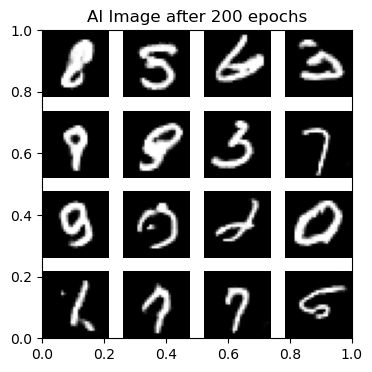

.........................

.........................

.........................



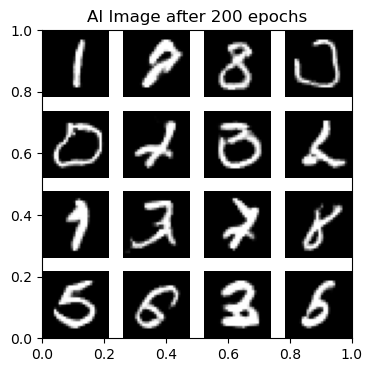




Percentage of correct predictions from the discriminator for ORIGINAL TEST images is 67.5
Percentage of correct predictions from the discriminator for GENERATED images is 60.0
Percentage of INcorrect predictions from the discriminator for GENERATED images is 40.0


In [33]:
EPOCHS=200
run_adam_legacy_optimizer()
run_DCGAN(x_train, x_test, EPOCHS)

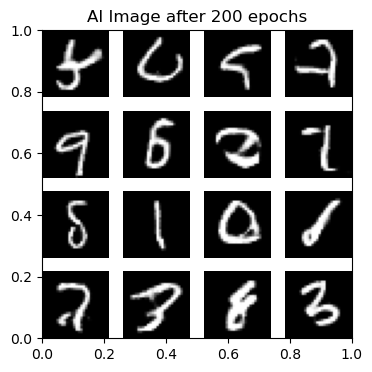

In [34]:
generate_image(EPOCHS)

In [38]:
run_percentage_error(x_test)




Percentage of correct predictions from the discriminator for ORIGINAL TEST images is 62.5
Percentage of correct predictions from the discriminator for GENERATED images is 45.0
Percentage of INcorrect predictions from the discriminator for GENERATED images is 55.0


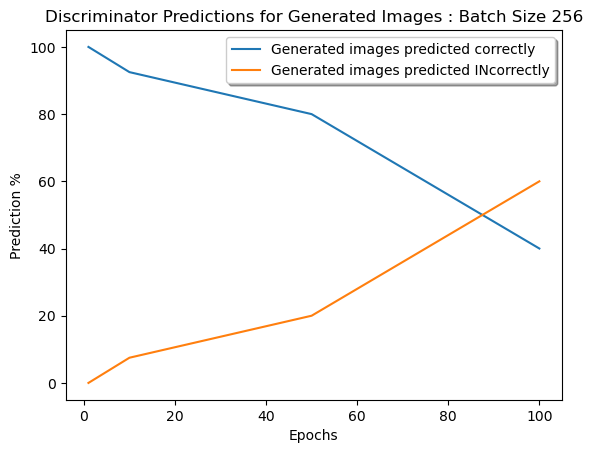

In [46]:
# batch size = 256

Correct_pred_for_gen_images_batch256=[100,92.5,80,40]
INcorrect_pred_for_gen_images_batch256=[0,7.5,20,60]
Epochs=[1,10,50,100]

dict_batch256 = {'Epochs':Epochs, 'Corret_pred':Correct_pred_for_gen_images_batch256, 'Incorrect_pred':INcorrect_pred_for_gen_images_batch256}

batch256 = pd.DataFrame(dict_batch256)


plt.plot(Epochs,Correct_pred_for_gen_images_batch256, label='Generated images predicted correctly')
plt.plot(Epochs,INcorrect_pred_for_gen_images_batch256, label='Generated images predicted INcorrectly')
plt.xlabel("Epochs")
plt.ylabel("Prediction %")
plt.title("Discriminator Predictions for Generated Images : Batch Size 256")
legend = plt.legend(loc='upper right', shadow=True, fontsize='medium')
plt.show()


## Batch Size

So far we ran tested the model and performed the epoch analysis at a batch size of 256. We will run try out a few other choices for batch size and determine the following :

1. the relatioship between batch size and run time/epoch (epochs = 1).
   Note: setting a higher number for epochs will not change the runtime/epoch.
    
2. the relatioship between batch size and error/accuracy of the discriminator for a fixed number of epochs.
   Note: We will have to set a high enough value for epochs to be able to determine possible fluctuations in error/accuracy. epochs=20 might be a fair place to start.

3. the influence the batch size has on the number of epochs needed for good accuracy. 

We will analyze our model with two other batch sizes:
- BATCH_SIZE = 128
- BATCH_SIZE = 512

##### Batch size Vs Accuracy (for a range of Epochs) 


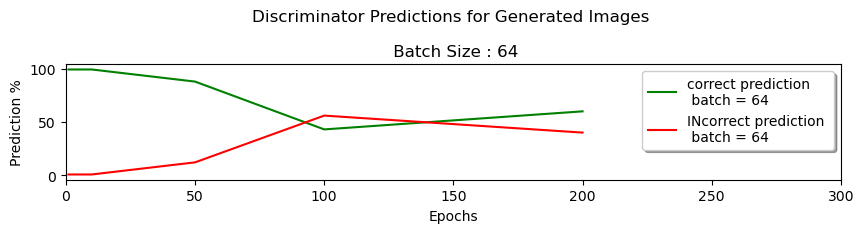

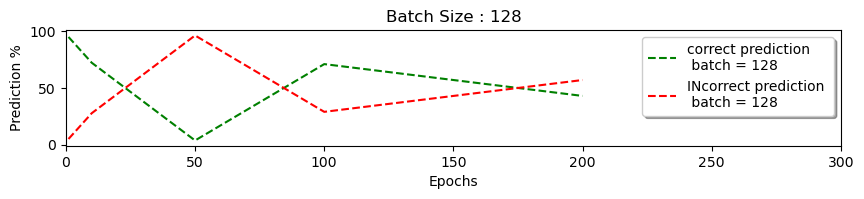

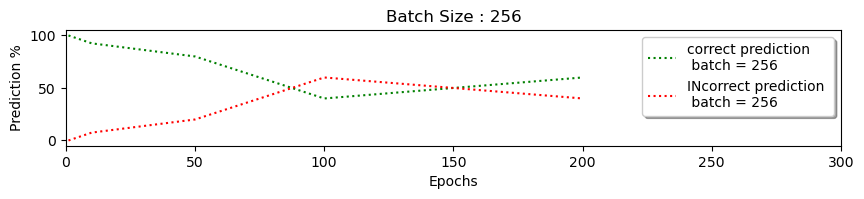

In [40]:
# batch size = 64
Correct_pred_for_gen_images_batch64=[99.4,99.4,88,43,60]
INcorrect_pred_for_gen_images_batch64=[0.6,0.6,12,56,40]

# batch size = 128
Correct_pred_for_gen_images_batch128=[94.9,72.2,3.8,71,43]
INcorrect_pred_for_gen_images_batch128=[5.1,27.8,96.2,29,57]

# batch size = 256
Correct_pred_for_gen_images_batch256=[100,92.5,80,40,60]
INcorrect_pred_for_gen_images_batch256=[0,7.5,20,60,40]

# batch size = 512
Correct_pred_for_gen_images_batch512=[0,0,0,0,0]
INcorrect_pred_for_gen_images_batch512=[0,0,0,0,0]


Epochs=[1,10,50,100,200]

'''
dict_batch64 = {'Epochs':Epochs, 'Corret_pred':Correct_pred_for_gen_images_batch64, 'Incorrect_pred':INcorrect_pred_for_gen_images_batch64}
dict_batch128 = {'Epochs':Epochs, 'Corret_pred':Correct_pred_for_gen_images_batch128, 'Incorrect_pred':INcorrect_pred_for_gen_images_batch128}
dict_batch256 = {'Epochs':Epochs, 'Corret_pred':Correct_pred_for_gen_images_batch256, 'Incorrect_pred':INcorrect_pred_for_gen_images_batch256}
dict_batch512 = {'Epochs':Epochs, 'Corret_pred':Correct_pred_for_gen_images_batch512, 'Incorrect_pred':INcorrect_pred_for_gen_images_batch512}

batch64 = pd.DataFrame(dict_batch64)
batch128 = pd.DataFrame(dict_batch128)
batch256 = pd.DataFrame(dict_batch256)
batch512 = pd.DataFrame(dict_batch512)
'''

plt.figure(figsize=(10,1.5))
plt.title("Discriminator Predictions for Generated Images \n\n Batch Size : 64")
plt.plot(Epochs,Correct_pred_for_gen_images_batch64,'g-', label='correct prediction \n batch = 64')
plt.plot(Epochs,INcorrect_pred_for_gen_images_batch64, 'r-',  label='INcorrect prediction \n batch = 64')
legend = plt.legend(loc='upper right', shadow=True, fontsize='medium')
plt.xlabel("Epochs")
plt.ylabel("Prediction %")
plt.xlim(0, 300)

plt.figure(figsize=(10,1.5))
plt.title("Batch Size : 128")
plt.plot(Epochs,Correct_pred_for_gen_images_batch128,'g--', label='correct prediction \n batch = 128')
plt.plot(Epochs,INcorrect_pred_for_gen_images_batch128, 'r--',  label='INcorrect prediction \n batch = 128')
legend = plt.legend(loc='upper right', shadow=True, fontsize='medium')
plt.xlabel("Epochs")
plt.ylabel("Prediction %")
plt.xlim(0, 300)

plt.figure(figsize=(10,1.5))
plt.title("Batch Size : 256")
plt.plot(Epochs,Correct_pred_for_gen_images_batch256,'g:',  label='correct prediction \n batch = 256')
plt.plot(Epochs,INcorrect_pred_for_gen_images_batch256,'r:',  label='INcorrect prediction \n batch = 256')
legend = plt.legend(loc='upper right', shadow=True, fontsize='medium')
plt.xlabel("Epochs")
plt.ylabel("Prediction %")
plt.xlim(0, 300)
plt.show()


## Noise dependance

As a final check, we will look into how the the choice of noise affects our model. We created the noise using a random normal distribution. It will be interesting to see how the model output changes for a different choice of noise. Here, we will study out model with noise sample from a Poisson distribution rather than a normal distribution. 

##### Poisson Noise

## Depth of the neural network 

We have tested and run with model with 3-4 hidden CNN layers. It is important to undertsand how the depth of the NN might affect our model. In other words, for a fixed batch size and fixed number of epochs, we need to determine how the depth of the NN (ie number of hidden layers) might affect the efficiency (ie runtime) and the effectiveness (error rate/accuracy) of our model?